7.361975422623531


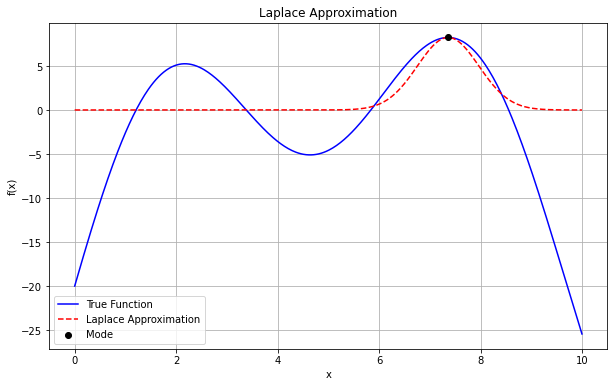

In [411]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal

# Define the original function f(x)
def f(x):
    return -(x - 5)**2 + 10 * np.sin(x) + 5

# Numerically find the mode of f(x)
result = minimize(lambda x: -f(x), x0=np.array([5]), method='L-BFGS-B')
x_mode = result.x[0]
print(x_mode)
# Second derivative (Hessian) at the mode - corrected for Laplace approximation
def hessian_at_mode(x):
    return -2 + 10 * np.cos(x)

hessian = hessian_at_mode(x_mode)

# Correctly handle variance computation for Laplace approximation
variance = 1 / hessian

# Define a range of x values for plotting
x_values = np.linspace(0, 10, 400)

# Calculate the true function values
true_values = f(x_values)

# Calculate the Laplace approximation (Gaussian centered at the mode)
laplace_approximation = norm.pdf(x_values, loc=x_mode, scale=np.sqrt(variance))

# Normalizing Laplace approximation for comparison purposes
laplace_approximation_normalized = laplace_approximation * np.max(true_values) / np.max(laplace_approximation)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, true_values, label='True Function', color='blue')
plt.plot(x_values, laplace_approximation_normalized, label='Laplace Approximation', linestyle='--', color='red')
plt.scatter(x_mode, f(x_mode), color='black', zorder=5, label='Mode')
plt.title('Laplace Approximation')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.savefig("Laplace.png")
plt.show()

In [399]:
f(x_mode)

8.234941188937253

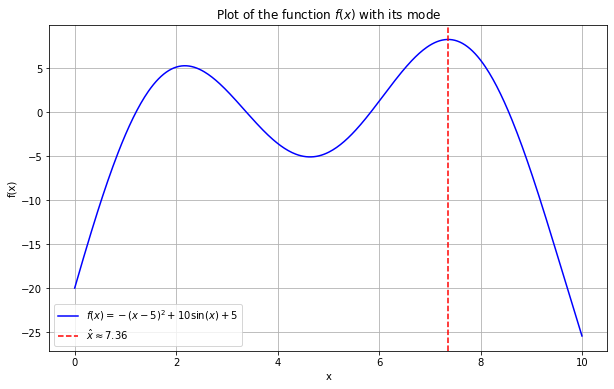

In [409]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function f(x)
def f(x):
    return -(x - 5)**2 + 10 * np.sin(x) + 5

# Generate a range of x values
x_values = np.linspace(0, 10, 400)

# Compute the function values for these x values
y_values = f(x_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='$f(x) = -(x - 5)^2 + 10 \\sin(x) + 5$', color='blue')
plt.axvline(x=x_mode, color='red', linestyle='--', label='$\hat{x} \\approx 7.36$')
plt.title('Plot of the function $f(x)$ with its mode')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.savefig("func.png")
plt.show()

In [29]:
class PerfumeDataset(torch.utils.data.Dataset):
    def __init__(self, bin_desc, ingr_filter = None):
        self.names = list(bin_desc.keys())
        self.binary_desc = bin_desc

    def __len__(self):
        return len(self.binary_desc.keys())

    def __getitem__(self, index):
        # Return the image and its filename
        if ingr_filter:
            
        return self.binary_desc[self.names[index]]

In [30]:
ingredients = json.loads(open("ingredients.json" ,"r").read())
parfums = json.loads(open("parfums.json" ,"r").read())

lexic = list(ingredients.keys())
lexic = sorted(lexic)

In [31]:
binary_desc = {}
for k in list(parfums.keys()):
    parfum_desc = parfums[k]
    binary_desc[parfum_desc["nom"]] = parfum_desc["Tête"] + parfum_desc["Coeur"] + parfum_desc["Fond"] 
    bin_v = np.zeros(len(lexic))
    for i in binary_desc[parfum_desc["nom"]]:
        bin_v[lexic.index(i)] = 1
    binary_desc[parfum_desc["nom"]] = bin_v

In [32]:
dataset = PerfumeDataset(binary_desc, best_ingredients)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [59]:
k_best = 10
parfums_ingredients = np.vstack([dataset[i] for i in range(len(dataset))])
best_ingredients = list(np.argsort(parfums.sum(axis = 0))[::-1][:k_best])
parfums_ingredients = parfums[:, best_ingredients]

In [111]:
def sample_columns_by_distribution(matrix, norm_factor = 1 ):
    # Compute the sum of each column
    column_sums = matrix.sum(dim=0)
    # Normalize to get a probability distribution
    probabilities = column_sums / column_sums.sum()    
    probabilities = probabilities / norm_factor
    # Sample column indices based on the normalized sums
    num_columns = matrix.size(1)
    sampled_indices = torch.multinomial(probabilities, num_samples=np.random.randint(1, num_columns+1), replacement=False)
    # Select the sampled columns from the matrix
    sampled_columns = matrix[:, sampled_indices]
    return sampled_columns, sampled_indices

def count_activated_rows(matrix, columns):
    # Index the matrix to get the relevant columns
    selected_columns = matrix[:, columns]
    
    # Check each row to see if any of the selected columns are True (1)
    activated_rows = selected_columns.any(dim=1)
    
    # Count the number of rows that have at least one True value
    count = activated_rows.sum().item()  # Convert to a Python integer
    
    return count

In [119]:
def sampling_data(parfums_ingredients, evaluations = 200):
    evaluations = {}
    i = 0
    while i<100:
        matrix, indices = sample_columns_by_distribution(torch.Tensor(parfums_ingredients))
        if not indices in evaluations:
            v = count_activated_rows(torch.Tensor(parfums_ingredients), torch.Tensor(indices))
            indices = tuple(sorted((int(i) for i in indices)))
            evaluations[indices] = np.array(v) / matrix.shape[0]
            i = i + 1
    R = []
    for c1 in evaluations:
        for c2 in evaluations:
            if c1 == c2:
                continue
            v_c1 = np.zeros(parfums_ingredients.shape[1])
            v_c2 = np.zeros(parfums_ingredients.shape[1])
            v_c1[list(c1)] = 1
            v_c2[list(c2)] = 1
            if evaluations[c1] > evaluations[c2] and len(c1) <= len(c2):
                R.append(v_c1 - v_c2)
    R = np.array(R)
    return evaluations, R

In [575]:
k_best = 20
parfums_ingredients = np.vstack([dataset[i] for i in range(len(dataset))])
best_ingredients = list(np.argsort(parfums.sum(axis = 0))[::-1][:k_best])
parfums_ingredients = parfums[:, best_ingredients]

evaluations, R = sampling_data(parfums_ingredients)

In [576]:
num_features = R.shape[1]  # Assuming the second dimension of A represents features
w = torch.randn(num_features, requires_grad=True)  # Initialize weights
np.sum(np.sign(R @ w.detach().numpy())) / R.shape[0]

-0.0219435736677116

In [577]:
def log_likelihood(w, R, sigma_f):
    standard_normal = Normal(0, 1)
    utility_diff = R @ w
    probit_values = standard_normal.cdf(utility_diff / (2 * sigma_f))
    log_prob = torch.log(probit_values)
    return log_prob.sum()

def log_prior(w, sigma_w):
    return -torch.sum((w / sigma_w)**2) / 2

def neg_log_posterior(w, R, sigma_f, sigma_w):
    return -log_likelihood(w, R, sigma_f) - log_prior(w, sigma_w)

In [578]:
def optimize_weights(R, sigma_f=1, sigma_w=1, learning_rate=1e-2, num_steps=1000):
    num_features = R.size(1)
    w = torch.randn(num_features, requires_grad=True)
    optimizer = optim.SGD([w], lr=learning_rate)
    
    for step in range(num_steps):
        optimizer.zero_grad()
        loss = neg_log_posterior(w, R, sigma_f, sigma_w)
        loss.backward()
        optimizer.step()

        if step % 500 == 0:
            print(f"Step {step}: Negative Log Posterior = {loss.item()}")

    return w.detach()

In [579]:
w_map = optimize_weights(torch.Tensor(R))

Step 0: Negative Log Posterior = 413.0318603515625
Step 500: Negative Log Posterior = 73.79116821289062


In [580]:
np.sum(np.sign(R @ w_map.numpy())) / R.shape[0]

0.9122257053291536

In [581]:
from itertools import combinations

def expand_R(R, d):
    R_p = R.clone()
    n, m = R.shape

    for interaction_level in range(2, d+1):
        for cols in combinations(range(m), interaction_level):
            new_col = torch.prod(R[:, cols], dim=1, keepdim=True)
            R_p = torch.cat((R_p, new_col), dim=1)
            
    return R_p.float()

In [582]:
R_1 = expand_R(torch.tensor(R), 1)

In [583]:
w_map = optimize_weights(R_1.float(), sigma_f = 1.2, sigma_w = 2, num_steps=5000)

Step 0: Negative Log Posterior = 215.42510986328125
Step 500: Negative Log Posterior = 58.533531188964844
Step 1000: Negative Log Posterior = 58.501991271972656
Step 1500: Negative Log Posterior = 58.500038146972656
Step 2000: Negative Log Posterior = 58.499916076660156
Step 2500: Negative Log Posterior = 58.49990463256836
Step 3000: Negative Log Posterior = 58.49991226196289
Step 3500: Negative Log Posterior = 58.49991226196289
Step 4000: Negative Log Posterior = 58.499908447265625
Step 4500: Negative Log Posterior = 58.499908447265625


In [584]:
np.sum(np.sign(np.array(R_1) @ w_map.numpy())) / R_1.shape[0]

0.9122257053291536

In [585]:
R_2 = expand_R(torch.tensor(R), 2)

In [586]:
w_map = optimize_weights(R_2.float(), sigma_f = 2, sigma_w = 1, num_steps=5000)

Step 0: Negative Log Posterior = 381.6091613769531
Step 500: Negative Log Posterior = 70.18324279785156
Step 1000: Negative Log Posterior = 70.18171691894531
Step 1500: Negative Log Posterior = 70.18171691894531
Step 2000: Negative Log Posterior = 70.18171691894531
Step 2500: Negative Log Posterior = 70.18171691894531
Step 3000: Negative Log Posterior = 70.18171691894531
Step 3500: Negative Log Posterior = 70.18171691894531
Step 4000: Negative Log Posterior = 70.18171691894531
Step 4500: Negative Log Posterior = 70.18171691894531


In [587]:
np.sum(np.sign(np.array(R_2) @ w_map.numpy())) / R_2.shape[0]

0.9937304075235109

In [588]:
def optimize_weights(R, sigma_f=1, sigma_w=1, learning_rate=1e-2, num_steps=1000):
    num_features = R.size(1)
    w = torch.randn(num_features, requires_grad=True)
    optimizer = optim.SGD([w], lr=learning_rate)
    
    for step in range(num_steps):
        optimizer.zero_grad()
        loss = neg_log_posterior(w, R, sigma_f, sigma_w)
        loss.backward()
        optimizer.step()

        if step % 500 == 0:
            print(f"Step {step}: Negative Log Posterior = {loss.item()}")

    return w, w.detach()

In [589]:
params, w_map = optimize_weights(R_2.float(), sigma_f = 2, sigma_w = 6e-1, num_steps=5000)

Step 0: Negative Log Posterior = 681.93310546875
Step 500: Negative Log Posterior = 104.243408203125
Step 1000: Negative Log Posterior = 104.243408203125
Step 1500: Negative Log Posterior = 104.243408203125
Step 2000: Negative Log Posterior = 104.243408203125
Step 2500: Negative Log Posterior = 104.243408203125
Step 3000: Negative Log Posterior = 104.243408203125
Step 3500: Negative Log Posterior = 104.243408203125
Step 4000: Negative Log Posterior = 104.243408203125
Step 4500: Negative Log Posterior = 104.243408203125


In [590]:
H = torch.autograd.functional.hessian(lambda w: neg_log_posterior(w, R_2.float(), sigma_f = 1.2, sigma_w = 1e-1), torch.Tensor(w_map))
regularization_strength = 1e-6
H_positive_definite = H - regularization_strength * torch.eye(H.size(0))

In [591]:
# Attempt Cholesky decomposition on the adjusted Hessian
chol_factor = torch.linalg.cholesky(H_positive_definite)

# Compute the inverse of the positive definite Hessian using the Cholesky factor
# This inverse serves as the covariance matrix for the Laplace approximation
covariance_matrix = torch.cholesky_inverse(chol_factor)

# Sampling from the Laplace approximation of the posterior
num_samples = 10000  # Desired number of samples
approx_posterior_samples = torch.distributions.MultivariateNormal(w_map, covariance_matrix).sample((num_samples,))

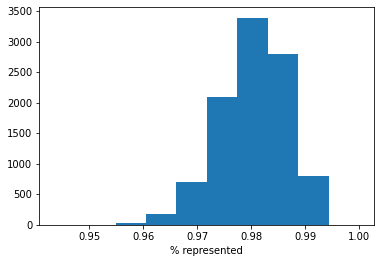

In [592]:
accs = []
for w in approx_posterior_samples:
    acc = np.sum(np.sign(np.array(R_2) @ w.numpy())) / R_2.shape[0]
    accs.append(acc)
plt.hist(accs)
plt.xlabel("% represented")
plt.savefig("histogram.png")

In [593]:
mat, ingr = sample_columns_by_distribution(torch.Tensor(parfums_ingredients))

In [594]:
ingrs = [lexic[i] for i in best_ingredients]

In [595]:
ingrs

['bergamote',
 'jasmin',
 'vanille',
 'patchouli',
 'rose',
 'muscs-blancs',
 'cedre',
 'santal',
 'mandarine',
 'citron',
 'vetiver',
 'fleur-doranger',
 'ambre',
 'iris',
 'feve-tonka',
 'musc',
 'lavande',
 'pamplemousse',
 'bois-ambres',
 'neroli']

In [633]:
c1 = np.zeros(len(best_ingredients))
c1[ingrs.index("bergamote")] = 1
c1[ingrs.index("vanille")] = 1
c1[ingrs.index("vetiver")]
c1 = c1.reshape((1,-1))
c1 = expand_R(torch.tensor(c1), 2)

In [634]:
c2 = np.zeros(len(best_ingredients))
c2[ingrs.index("fleur-doranger")] = 1
c2[ingrs.index("vanille")] = 1
c2[ingrs.index("ambre")] = 1
c2 = c2.reshape((1,-1))
c2 = expand_R(torch.tensor(c2), 2)

In [649]:
c1_hist = []
for w in approx_posterior_samples:
    v = ((c1) @ w).detach().numpy()
    c1_hist.append(v)
c1_hist = np.array(c1_hist)

In [650]:
c2_hist = []
for w in approx_posterior_samples:
    v = ((c2) @ w).detach().numpy()
    c2_hist.append(v)
c2_hist = np.array(c2_hist)

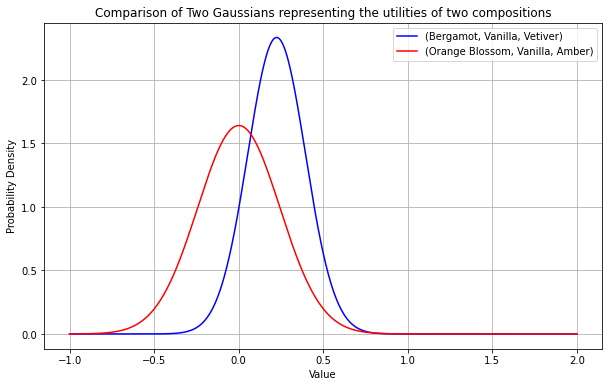

In [655]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Means and standard deviations for two normal distributions
mean1, std1 = c1_hist.mean(), c1_hist.std()
mean2, std2 = c2_hist.mean(), c2_hist.std()

# Generate points on the x axis
x = np.linspace(-1, 2, 1000)

# Calculate the PDF (Probability Density Function) for each distribution
pdf1 = norm.pdf(x, mean1, std1)
pdf2 = norm.pdf(x, mean2, std2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, pdf1, label=f'(Bergamot, Vanilla, Vetiver)', color='blue')
plt.plot(x, pdf2, label=f'(Orange Blossom, Vanilla, Amber)', color='red')
plt.title('Comparison of Two Gaussians representing the utilities of two compositions')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.savefig("Comparison.png")
plt.show()

In [656]:
mean1, std1,mean2, std2

(0.22453958, 0.1708538, 0.0007703294, 0.24302398)

In [659]:
from scipy.stats import norm

# Given means and standard deviations for the two Gaussian distributions
mu_1, sigma_1 = 0.22453958, 0.1708538
mu_2, sigma_2 = 0.0007703294, 0.24302398

# Calculate the mean and standard deviation for Z
mu_Z = mu_1 - mu_2
sigma_Z = (sigma_1**2 + sigma_2**2)**0.5

# Calculate the probability that the first Gaussian is greater than the second
probability = 1 - norm.cdf(-(mu_Z) / sigma_Z)

probability

0.7743500395319263

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


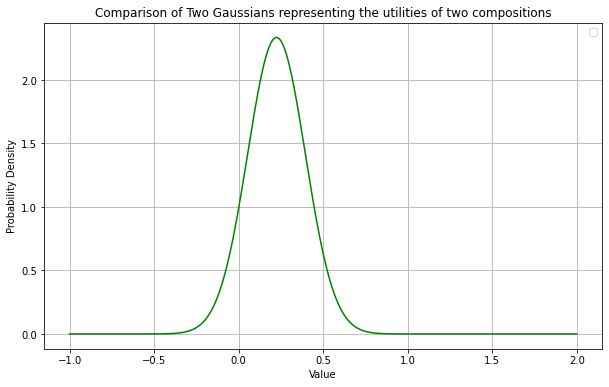

In [651]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Means and standard deviations for two normal distributions
mean1, std1 = c1_hist.mean() - c2_hist.mean(), c1_hist.std()

# Generate points on the x axis
x = np.linspace(-1, 2, 1000)

# Calculate the PDF (Probability Density Function) for each distribution
pdf1 = norm.pdf(x, mean1, std1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, pdf1, color='green')
#plt.plot(x, pdf2, label=f'(Orange Blossom, Vanilla, Amber)', color='red')
plt.title('Comparison of Two Gaussians representing the utilities of two compositions')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.savefig("Comparison.png")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


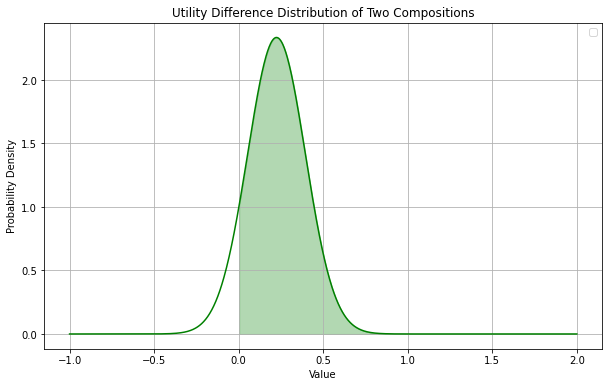

In [654]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Means and standard deviations for the Gaussian distribution
mean1, std1 = c1_hist.mean() - c2_hist.mean(), c1_hist.std()

# Generate points on the x axis
x = np.linspace(-1, 2, 1000)

# Calculate the PDF (Probability Density Function) for the distribution
pdf1 = norm.pdf(x, mean1, std1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, pdf1, color='green')
# Shade the area where the Gaussian is greater than 0
plt.fill_between(x, 0, pdf1, where=(x > 0), color='green', alpha=0.3)

plt.title('Utility Difference Distribution of Two Compositions')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.savefig("Substraction.png")
plt.show()

In [533]:
add, prec = [],[]
for i in range(1,4):
    R_i = expand_R(torch.tensor(R), i)
    params, w_map = optimize_weights(R_i.float(),learning_rate=5e-2, sigma_f = 2.5, sigma_w = 2, num_steps=5000)
    p = np.sum(np.sign(np.array(R_i) @ w_map.numpy())) / R_i.shape[0]
    add.append(i)
    prec.append(p)

Step 0: Negative Log Posterior = 217.32044982910156
Step 500: Negative Log Posterior = 94.01704406738281
Step 1000: Negative Log Posterior = 94.01704406738281
Step 1500: Negative Log Posterior = 94.01704406738281
Step 2000: Negative Log Posterior = 94.01704406738281
Step 2500: Negative Log Posterior = 94.01704406738281
Step 3000: Negative Log Posterior = 94.01704406738281
Step 3500: Negative Log Posterior = 94.01704406738281
Step 4000: Negative Log Posterior = 94.01704406738281
Step 4500: Negative Log Posterior = 94.01704406738281
Step 0: Negative Log Posterior = 469.48968505859375
Step 500: Negative Log Posterior = 48.502410888671875
Step 1000: Negative Log Posterior = 48.50239562988281
Step 1500: Negative Log Posterior = 48.50239562988281
Step 2000: Negative Log Posterior = 48.50239562988281
Step 2500: Negative Log Posterior = 48.50239562988281
Step 3000: Negative Log Posterior = 48.50239562988281
Step 3500: Negative Log Posterior = 48.50239562988281
Step 4000: Negative Log Posterior

ValueError: Expected value argument (Tensor of shape (307,)) to be within the support (Real()) of the distribution Normal(loc: 0.0, scale: 1.0), but found invalid values:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       grad_fn=<DivBackward0>)

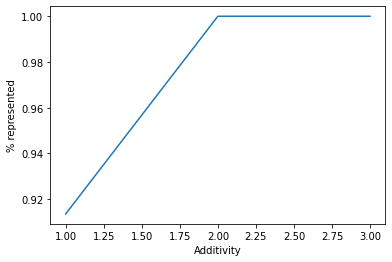

In [450]:
plt.plot(add, prec)
plt.xlabel("Additivity")
plt.ylabel("% represented")
plt.savefig("represented.png")

In [442]:
prec

[0.8827160493827161, 0.9876543209876543]

In [500]:
k_best = 20
parfums_ingredients = np.vstack([dataset[i] for i in range(len(dataset))])
best_ingredients = list(np.argsort(parfums.sum(axis = 0))[::-1][:k_best])
parfums_ingredients = parfums[:, best_ingredients]

evaluations, R = sampling_data(parfums_ingredients)

In [507]:
R_i = expand_R(torch.tensor(R), 2)

In [508]:
params, w_map = optimize_weights(R_i.float(), sigma_f = 4, sigma_w = 6e-1, num_steps=5000)

Step 0: Negative Log Posterior = 577.2718505859375
Step 500: Negative Log Posterior = 123.30743408203125
Step 1000: Negative Log Posterior = 123.30743408203125
Step 1500: Negative Log Posterior = 123.30743408203125
Step 2000: Negative Log Posterior = 123.30743408203125
Step 2500: Negative Log Posterior = 123.30743408203125
Step 3000: Negative Log Posterior = 123.30743408203125
Step 3500: Negative Log Posterior = 123.30743408203125
Step 4000: Negative Log Posterior = 123.30743408203125
Step 4500: Negative Log Posterior = 123.30743408203125


In [509]:
w_map.shape

torch.Size([210])

In [510]:
np.sum(np.sign(np.array(R_i) @ w_map.numpy())) / R_i.shape[0]

0.9774436090225563